## Association Rules Market Basket Analysis

In this pandemic situation, mostly everyone bought their needs online. When we bought items in the e-commerce site, it would made something pattern to one item to another item you bought. It can be advantages because it will runs recommendation algorithms based on the item-search history of the customer to improve the shopping experience, and it works pretty much same for the offline retailers.

An example when we make a promotion about Bread and Jam to make customers buy them both together then could increase the sales.

This entire process of analyzing the shopping trends of customers is called **‘Market Basket Analysis’**. It is an analyzing technique based on the idea that if we buy an item then we are bound to buy or not-buy a group (or single) items. For example, if a customer is buying bread then the chances of him/her buying jam is more.


## Import Package

Let's do the analysis on the retail data transaction in each country with pandas for data frame, and mlxtend lib for the market basket analysis algorithms.

Load the necessary libraries:

In [1]:
# library
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

## Load Data

Load the data into a pandas data-frame and use head() to see the top five of the data and also the columns.


In [2]:
# load data to dataframe
df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


The description about the columns name as follows:						

1. InvoiceNo - Unique identifier of a invoice/transaction
2. StockCode - Unique identifier of stock in a products
3. Description - Description of the product purchased
4. Quantity - The number of the product purchased in the transaction
5. InvoiceDate - Time at which the invoice/transaction is performed
6. UnitPrice - Price per each unit of the product
7. CustomerID - Country from which the purchase is made.

# Data Understanding

To know more about the data, we need to understand how many nulls in the data and also the profile of the data. So we need to check dimensions of the data, the number of unique transactions and the number of customers.

In [3]:
# data profile
print('Data dimension (total row, total column) : {dim}' .format(dim=df.shape))
print('Count of unique invoice number : {count}' .format(count=df.InvoiceNo.nunique()))
print('Number of customer ID : {count}' .format(count=df.CustomerID.nunique()))

Data dimension (total row, total column) : (541909, 8)
Count of unique invoice number : 25900
Number of customer ID : 4372


From the data we see that total row and total column of the data are 541909 and 8, with total unique product purchase and total customer are 25900 and 4372.

In [4]:
#number of 
df.isnull().sum(axis = 0)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

We see from the data we have null in the description and CustomerID columns. Cor this analysis, we will ignore the columns.

# Data Preparation

Here we do preparation data for analysis, the columns or the rows that we will use by filtering, expanding, or dropping columns.

In [5]:
df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['CustomerID'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')] # C is credit

In [6]:
df['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Finland',
       'Austria', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Israel', 'Saudi Arabia', 'Czech Republic',
       'Canada', 'Unspecified', 'Brazil', 'USA', 'European Community',
       'Bahrain', 'Malta', 'RSA'], dtype=object)

Country that we will use is France and to focus of the unique products in each transactions, so we need to filter the data. After the data were done for the pre-processing, then will arrange it with the InvoiceNo’s as the index and the Description as the columns with the total no. of items bought in each transaction of each item as the data-point.

In [7]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [8]:
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D HEARTS HONEYCOMB PAPER GARLAND,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS EMPIRE,...,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

Quite a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less the 0 is set to 0. so, let’s apply one hot encoding of the data and remove the postage column

In [9]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

# we are not going to explore postage. 
basket_sets.drop('POSTAGE', inplace=True, axis=1)

In [10]:
basket_sets

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,15CM CHRISTMAS GLASS BALL 20 LIGHTS,16 PIECE CUTLERY SET PANTRY DESIGN,18PC WOODEN CUTLERY SET DISPOSABLE,20 DOLLY PEGS RETROSPOT,200 RED + WHITE BENDY STRAWS,3 HOOK HANGER MAGIC GARDEN,3 PIECE SPACEBOY COOKIE CUTTER SET,3 RAFFIA RIBBONS 50'S CHRISTMAS,3 STRIPEY MICE FELTCRAFT,3 TIER CAKE TIN RED AND CREAM,3 TRADITIONAl BISCUIT CUTTERS SET,36 DOILIES DOLLY GIRL,36 DOILIES VINTAGE CHRISTMAS,36 FOIL HEART CAKE CASES,36 FOIL STAR CAKE CASES,36 PENCILS TUBE RED RETROSPOT,36 PENCILS TUBE SKULLS,36 PENCILS TUBE WOODLAND,3D HEARTS HONEYCOMB PAPER GARLAND,3D TRADITIONAL CHRISTMAS STICKERS,3D VINTAGE CHRISTMAS STICKERS,4 IVORY DINNER CANDLES SILVER FLOCK,4 PINK DINNER CANDLE SILVER FLOCK,4 TRADITIONAL SPINNING TOPS,5 HOOK HANGER MAGIC TOADSTOOL,5 HOOK HANGER RED MAGIC TOADSTOOL,50'S CHRISTMAS GIFT BAG LARGE,6 GIFT TAGS 50'S CHRISTMAS,6 GIFT TAGS VINTAGE CHRISTMAS,6 RIBBONS EMPIRE,...,WOODLAND CHARLOTTE BAG,WOODLAND DESIGN COTTON TOTE BAG,WOODLAND LARGE BLUE FELT HEART,WOODLAND LARGE PINK FELT HEART,WOODLAND LARGE RED FELT HEART,WOODLAND MINI BACKPACK,WOODLAND PARTY BAG + STICKER SET,WOODLAND SMALL BLUE FELT HEART,WOODLAND SMALL PINK FELT HEART,WOODLAND SMALL RED FELT HEART,WOODLAND STORAGE BOX LARGE,WOODLAND STORAGE BOX SMALL,WORLD WAR 2 GLIDERS ASSTD DESIGNS,WRAP VINTAGE DOILY,WRAP 50'S CHRISTMAS,WRAP ALPHABET DESIGN,WRAP CAROUSEL,WRAP CHRISTMAS VILLAGE,WRAP CIRCUS PARADE,WRAP DOILEY DESIGN,WRAP DOLLY GIRL,WRAP ENGLISH ROSE,WRAP GINGHAM ROSE,WRAP GREEN PEARS,WRAP I LOVE LONDON,WRAP PAISLEY PARK,WRAP PINK FAIRY CAKES,WRAP POPPIES DESIGN,WRAP RED APPLES,WRAP RED VINTAGE DOILY,WRAP SUKI AND FRIENDS,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
536370,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536852,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
536974,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537065,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
537463,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
581171,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# Modeling

After the data have done for the preparation, then we build the model to make the algoritms of market basket analysis to get the frequently bought item-sets.

To use market basket analysis, there are a few metrics for measuring associations, as follows: 
1.   Support: The combination of items bought together frequently.
2.   Confidence: How frequently the items a item and another item are bought together, for the no. of times a item is bought.
3. Lift: The strength of a rule over the randomness of items and another items are being bought together. 



Here the minimum threshold support value is set as 5%. 

In [24]:
# set minimum support
frequent_itemsets = apriori(basket_sets, min_support=0.05, use_colnames=True)

We get the following item-sets.

In [25]:
# list of rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.097686,0.102828,0.074550,0.763158,7.421711,0.064505,3.788061
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102828,0.097686,0.074550,0.725000,7.421711,0.064505,3.281140
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.097686,0.095116,0.079692,0.815789,8.576814,0.070400,4.912229
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095116,0.097686,0.079692,0.837838,8.576814,0.070400,5.564267
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102828,0.095116,0.074550,0.725000,7.622297,0.064770,3.290488


In [26]:
# total number of association rule
print('"number of association" {}'. format(rules.shape[0]))

"number of association" 86


There are a total of 86 rules of the association.

The distribution of confidence metrics you could see below.

Text(0.5, 1.0, 'Confidence')

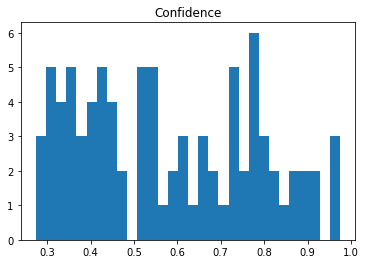

In [27]:
# plot confidence results
rules.hist('confidence', grid =False, bins =30)
plt.title("Confidence")

The distribution of lift metrics you could see below.

Text(0.5, 1.0, 'Lift')

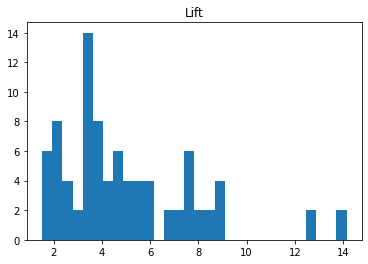

In [28]:
# plot lift results
rules.hist('lift', grid =False, bins =30)
plt.title("Lift")

## Results

From the distribution of both metrics, we will choose lift at 2 and confidence at 0.5 as follows:

In [29]:
# set minumum lift and confidence
rules[ (rules['lift'] >= 2) &
       (rules['confidence'] >= 0.5) ]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.097686,0.102828,0.074550,0.763158,7.421711,0.064505,3.788061
1,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.102828,0.097686,0.074550,0.725000,7.421711,0.064505,3.281140
2,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.097686,0.095116,0.079692,0.815789,8.576814,0.070400,4.912229
3,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095116,0.097686,0.079692,0.837838,8.576814,0.070400,5.564267
4,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.102828,0.095116,0.074550,0.725000,7.622297,0.064770,3.290488
5,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095116,0.102828,0.074550,0.783784,7.622297,0.064770,4.149422
7,(ALARM CLOCK BAKELIKE RED),(ROUND SNACK BOXES SET OF4 WOODLAND),0.095116,0.159383,0.051414,0.540541,3.391456,0.036254,1.829578
8,(CHILDRENS CUTLERY SPACEBOY),(CHILDRENS CUTLERY DOLLY GIRL),0.069409,0.071979,0.064267,0.925926,12.863757,0.059271,12.528278
9,(CHILDRENS CUTLERY DOLLY GIRL),(CHILDRENS CUTLERY SPACEBOY),0.071979,0.069409,0.064267,0.892857,12.863757,0.059271,8.685518
10,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.100257,0.125964,0.071979,0.717949,5.699634,0.059351,3.098855


From here we hava all the required item-sets can be found. We can download the found item-sets to a csv file for furtherance.